# Calculate Fluxes for HPD-hist 

In [1]:
import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
xgb_hpd_dir = f'/data/artemis/workspace/vbennington/LDEO_HPD/models/XGB/Lukes_with_xco2'

models = ['cesm_spco2_1x1_A', 
               'csiro_spco2_1x1_A',
               'fesom_spco2_1x1_A',
               'mpi_spco2_1x1_A', 
               'cnrm_spco2_1x1_A',
               'ipsl_spco2_1x1_A',
               'planktom_spco2_1x1_A',
               'noresm_spco2_1x1_A',
               'princeton_spco2_1x1_A',]
modname = ['cesm', 
               'csiro',
               'fesom',
               'mpi', 
               'cnrm',
               'ipsl',
               'planktom',
               'noresm',
               'princeton',]

In [3]:
# Set up directories and Flux Kit File
run_dir = "/data/artemis/workspace/vbennington/LDEO_HPD/models/XGB/clim_corrected/2000_2018_clim"

fk = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/FluxKit_calculation_1982-2019_v20201120.nc')

k_ds = xr.open_dataset("/data/artemis/workspace/vbennington/LDEO_HPD/data_for_flux/NOAA_ERSST_K0_kw_atmos_pco2_1959-2019.nc")
gat = xr.open_dataset("/data/artemis/observations/SOCOM/extra_files/SeaFlux_v2021.04_pco2atm_1982-2020.nc")
fk['time'] = k_ds['time'][-420:-12]

kw = k_ds.kw * (24/100)  #cm/hr --> m/day
K0 = k_ds.K0/1000 # mmol / m3 / atm  --> mol/m3/uatm
mC = 12.0108 # g / mol
pCO2air = k_ds.carbo_scope_pco2 # micro atmospheres
icef = k_ds.ice


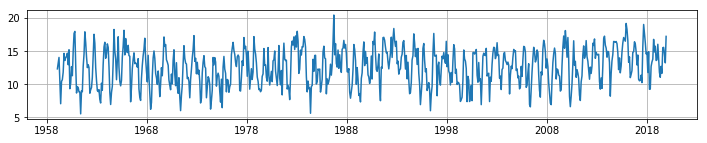

In [4]:
# Spot check piston velocity

fig = plt.figure(figsize=(12,2))
plt.plot(k_ds.time,k_ds.kw[:,90,130])
plt.grid(True)


In [5]:
# Load HPD Historical 
# 1958-1981 filled with climatological correction of 2000-2018
# 1982 to 2018 uses original HPD corrections

i = 0

tmp_ds = xr.open_dataset(f'{run_dir}/{modname[i]}_clim_corrected_gcbA2020.nc')
tmp_ds['hpd_hist']=tmp_ds[f'{modname[i]}_corrected_spco2']*0

# add all predictions together
for mod in models: 
    
    # load model output:
    ds = xr.open_dataset(f'{run_dir}/{modname[i]}_clim_corrected_gcbA2020.nc')
    tmp_ds['hpd_hist'] += ds[f'{modname[i]}_corrected_spco2']
    
    del ds
    i+=1
    
#replace longitude from 0-360 to -180 to 180
tmp_ds['lon'] = list(map(lambda x: x-360 if x>180 else x, tmp_ds['lon'].values))
# Sort by longitude
tmp_ds = tmp_ds.sortby('lon')
tmp_ds['hpd_hist'] = tmp_ds['hpd_hist']/len(models) 

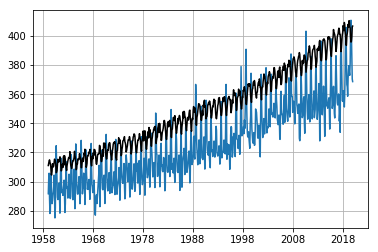

In [6]:
# Fill the coasts with adjusted coastal spco2
################################################

coast=xr.open_dataset('/data/artemis/workspace/vbennington/LDEO_HPD/data_for_flux/coastal_scaling_map_centered_2006.nc')

hpd_filled = tmp_ds['hpd_hist'].sel(time=slice("01-01-1959","12-31-2019")).fillna(coast.spco2_scale_clim)
fig = plt.figure()
plt.plot(hpd_filled.time,hpd_filled[:,130,140])
plt.grid(True)
plt.plot(hpd_filled.time,pCO2air[:,130,140],'black')

In [7]:
pCO2sea = hpd_filled
      #.  (m/day)*(mmol/m3/atm)*(atm)*(g/mmol) = (g/m2/day)
co2_flux = kw * K0 * (pCO2sea - pCO2air) * (1-icef) * mC * 365 # g / m2 / year

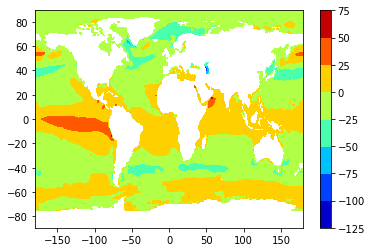

In [8]:
fig = plt.figure()
plt.contourf(co2_flux.lon,co2_flux.lat,co2_flux.mean("time"),cmap='jet')
plt.colorbar()

In [9]:
# Only look at open ocean:
mask = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/RECCAP2_region_masks_all.nc') 
#replace longitude from 0-360 to -180 to 180
mask['lon'] = list(map(lambda x: x-360 if x>180 else x, mask['lon'].values))
# Sort by longitude
mask = mask.sortby('lon')

flux_region = (co2_flux.where(mask['open_ocean']>=1)*(fk.area)).sum(['lat','lon'])

In [10]:
# Integrate the flux #
######################
int_flux = flux_region.groupby("time.year").mean("time")

Text(0.5,1,'HPD Historical Flux - CarboScope pCO2')

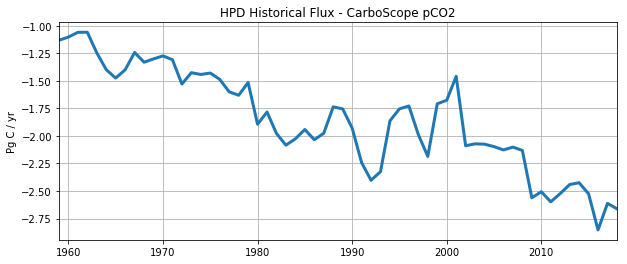

In [11]:
fig = plt.figure(figsize=(10,4))
plt.plot(int_flux.year.sel(year=slice(1959,2018)),int_flux.sel(year=slice(1959,2018))/10**15-0.49,linewidth=3)
plt.grid(True)
plt.xlim(1959,2018)
plt.ylabel("Pg C / yr")
plt.title("HPD Historical Flux - CarboScope pCO2")

# Compare to GCB Modeled Fluxes

In [12]:
dm = xr.open_dataset('/data/artemis/simulations/GCB/2020models/gcb_load_A_2020.nc',decode_times=False)
dm = dm.rename({'X':'lon','Y':'lat','T':'time'})
dm['lon'] = list(map(lambda x: x-360 if x>180 else x, dm['lon'].values))
dm = dm.sortby('lon')
dm['time']=pd.date_range(start=f'1958-01T00:00:00.000000000',end=f'2019-12T00:00:00.000000000',freq='MS') + np.timedelta64(14, 'D')

In [13]:
print(dm.cesm_fgco2_1x1_A.attrs)
print(dm.cesm_fgco2_1x1_A.coords)

{'units': 'molC/m^2/s', 'long_name': 'cesm_fgco2_1x1_A'}
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1958-01-15 1958-02-15 ... 2019-12-15


In [14]:
# variable for flux:
# fgco2 (mol C / m2 / sec)
# Each model is global, so no need to fill coasts

models = ['cesm_fgco2_1x1_A', 
               'csiro_fgco2_1x1_A',
               'fesom_fgco2_1x1_A',
               'mpi_fgco2_1x1_A', 
               'cnrm_fgco2_1x1_A',
               'ipsl_fgco2_1x1_A',
               'planktom_fgco2_1x1_A',
               'noresm_fgco2_1x1_A',
               'princeton_fgco2_1x1_A',]
modname = ['cesm', 
               'csiro',
               'fesom',
               'mpi', 
               'cnrm',
               'ipsl',
               'planktom',
               'noresm',
               'princeton',]

In [39]:
# To integrate flux
# Sum of: (area * (mol C / m2 / sec)) --> mol C / sec
# (mol C / sec) * (365*24*60*60)  --> mol C / year
# (mol C / year) * 12.01 g/mol  ---> g C / year
# (g C / yr ) / 10**15 --> Pg C / year

In [15]:
# Do the calculations to get annual mean fluxes:

m = 0
for mod in models: # loop on different model fluxes
    # grab gridded flux and multiply by area:
    gflux = (dm[f'{mod}'].where(mask['open_ocean']>=1)*(fk.area)).sum(['lat','lon']).groupby("time.year").mean("time")
    dm[f"{modname[m]}_annual_flux"] = gflux * (365*24*60*60) * 12.01 / (10**15)
    del gflux
    m += 1

Text(0.5,1,'GCB Models and HPD-Hist CO2 Flux')

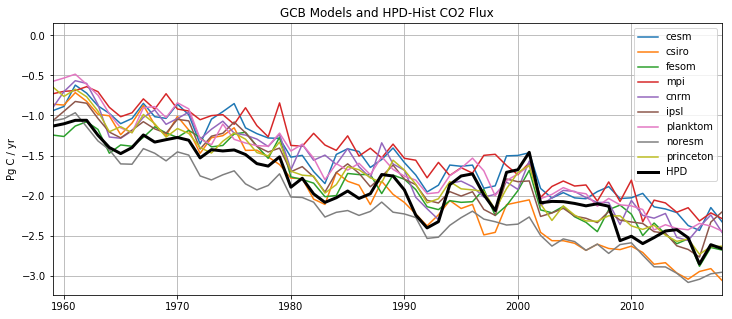

In [65]:
fig = plt.figure(figsize=(12,5))
for m in range(0,len(models)):
    var = dm[f"{modname[m]}_annual_flux"]
    plt.plot(var.year,-1*var.values,label=f"{modname[m]}")
    del var
# Add HPD-Hist:
plt.plot(int_flux.year.sel(year=slice(1959,2018)),int_flux.sel(year=slice(1959,2018))/10**15-0.49,color='black',linewidth=3,label='HPD')
plt.xlim(1959,2018)
plt.grid(True)
plt.ylabel("Pg C / yr")
plt.legend()
plt.title("GCB Models and HPD-Hist CO2 Flux")


In [20]:
#modname = ['cesm','csiro','fesom','mpi','cnrm','ipsl','planktom','noresm','princeton',]

In [35]:
# Write Files so as not to repeat

ds_flux = {}

for m in range(0,len(models)):
    ds_flux[f"{modname[m]}_annual_flux"] = -1* dm[f"{modname[m]}_annual_flux"].sel(year=slice("1959","2018"))
    m+=1
# Add HPD-Hist:
ds_flux['hpd_annual_flux']=int_flux.sel(year=slice(1959,2018))/10**15-0.49

# Write to File to not repeat

In [36]:
DS = xr.merge([ds_flux['cesm_annual_flux'].to_dataset(name='cesm'), ds_flux['csiro_annual_flux'].to_dataset(name='csiro'), ds_flux['fesom_annual_flux'].to_dataset(name='fesom'), ds_flux['mpi_annual_flux'].to_dataset(name='mpi'), 
               ds_flux['cnrm_annual_flux'].to_dataset(name='cnrm'), ds_flux['ipsl_annual_flux'].to_dataset(name='ipsl'), ds_flux['planktom_annual_flux'].to_dataset(name='planktom'), ds_flux['noresm_annual_flux'].to_dataset(name='noresm'),
               ds_flux['princeton_annual_flux'].to_dataset(name='princeton'), ds_flux['hpd_annual_flux'].to_dataset(name='hpd')], compat='override', join='override')

In [38]:
DS.attrs['units'] = "Pg C / yr"
DS.attrs['more info'] = "negative into the ocean"
DS['hpd'].attrs['more info']="2000-2018 clim correction applied prior to 1982; 0.49 river flux adjustment"
DS.attrs['description'] = "annual mean CO2 fluxes - calculated using CarboScope atmospheric CO2 for HPD" 
DS.to_netcdf("/data/artemis/workspace/vbennington/LDEO_HPD/models/XGB/clim_corrected/2000_2018_clim/hpd_model_annual_co2_fluxes.nc")

## Compare to Data Products

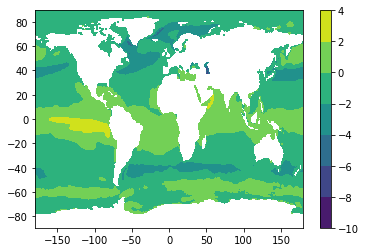

In [44]:
seaflux = xr.open_dataset("/data/artemis/observations/SOCOM/extra_files/SeaFlux_v2021.04_fgco2_all_winds_products.nc")
# fgco2 (product, wind, time, lat, lon)
fig = plt.figure()
plt.contourf(seaflux.lon,seaflux.lat,seaflux.fgco2.sel(product="CSIR_ML6").mean(["wind","time"]))
plt.colorbar()

In [52]:
# For the data products:
pflux = {}
for prod in seaflux.product.values:
    print(prod)
    pflux[f"{prod}"] = (seaflux.fgco2.sel(product=prod).mean("wind").where(mask['open_ocean']>=1)*(fk.area)).sum(['lat','lon']).groupby("time.year").mean("time")* 12.01 / (10**15)

JENA_MLS
MPI_SOMFFN
CMEMS_FFNN
CSIR_ML6
JMA_MLR
NIES_FNN


In [55]:
DP = xr.merge([pflux['JENA_MLS'].to_dataset(name='JENA_MLS'), pflux['MPI_SOMFFN'].to_dataset(name='MPI_SOMFFN'), 
               pflux['CMEMS_FFNN'].to_dataset(name='CMEMS_FFNN'), pflux['CSIR_ML6'].to_dataset(name='CSIR_ML6'), 
               pflux['JMA_MLR'].to_dataset(name='JMA_MLR'), pflux['NIES_FNN'].to_dataset(name='NIES_FNN')], 
              compat='override', join='override')

In [ ]:
DP.attrs['units'] = "Pg C / yr"
DP.attrs['more info'] = "negative into the ocean, mean winds, no river flux adjustment"
DP.attrs['description'] = "annual mean CO2 fluxes - from SeaFlux_v2021.04_fgco2_all_winds_products.nc" 
DP.to_netcdf("/data/artemis/observations/SOCOM/extra_files/product_annual_co2_fluxes.nc")

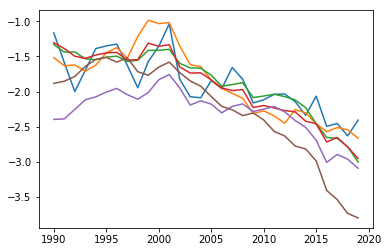

In [58]:
fig = plt.figure()
for prod in seaflux.product.values:
    plt.plot(DP.year,DP[f"{prod}"],label=prod)

## Models and Products on 1 Plot

Text(0.5,1,'GCB Models and HPD-Hist CO2 Flux')

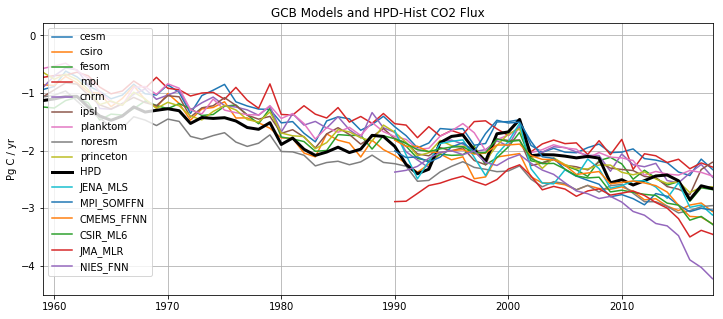

In [66]:
## Plot models and Data Products Together:
fig = plt.figure(figsize=(12,5))
for m in range(0,len(models)):
    var = dm[f"{modname[m]}_annual_flux"]
    plt.plot(var.year,-1*var.values,label=f"{modname[m]}")
    del var
# Add HPD-Hist:
plt.plot(int_flux.year.sel(year=slice(1959,2018)),int_flux.sel(year=slice(1959,2018))/10**15-0.49,color='black',linewidth=3,label='HPD')
# Add Data Products:
for prod in seaflux.product.values:
    plt.plot(DP.year,DP[f"{prod}"]-0.49,label=prod)
plt.xlim(1959,2018)
plt.grid(True)
plt.ylabel("Pg C / yr")
plt.legend()
plt.title("GCB Models and HPD-Hist CO2 Flux")

## Mean/STD of Models and Products

In [86]:
# Means
# Products
prod_mean = DP['JMA_MLR']*0
for prod in seaflux.product.values:
    prod_mean += DP[f"{prod}"]
prod_mean = prod_mean / len(seaflux.product.values)

# Models
model_mean = dm[f"{modname[m]}_annual_flux"].sel(year=slice(1959,2018))*0
for m in range(0,len(models)):
    model_mean += -1* dm[f"{modname[m]}_annual_flux"].sel(year=slice(1959,2018))
model_mean = model_mean / len(models)

In [76]:
# Standard Deviations
# Products
all_products = np.empty(shape=(6,30))
all_products[0,:] = DP['JENA_MLS']
all_products[1,:] = DP['MPI_SOMFFN']
all_products[2,:] = DP['CMEMS_FFNN']
all_products[3,:] = DP['CSIR_ML6']
all_products[4,:] = DP['JMA_MLR']
all_products[5,:] = DP['NIES_FNN']
product_std = np.nanstd(all_products,axis=0)

# models
all_models = np.empty(shape=(9,60))  # Don't include our HPD
all_models[0,:] = DS['cesm']
all_models[1,:] = DS['csiro']
all_models[2,:] = DS['fesom']
all_models[3,:] = DS['mpi']
all_models[4,:] = DS['cnrm']
all_models[5,:] = DS['ipsl']
all_models[6,:] = DS['planktom']
all_models[7,:] = DS['noresm']
all_models[8,:] = DS['princeton']
model_std = np.nanstd(all_models,axis=0)

Text(0,0.5,'Pg C / yr')

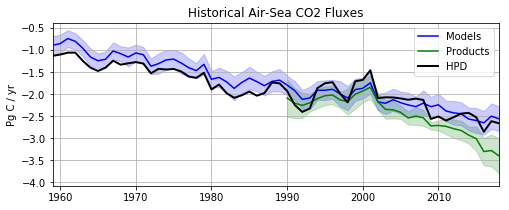

In [95]:
fig = plt.figure(figsize=(8,3))
plt.plot(model_mean.year,model_mean,color='blue',label="Models")
plt.fill_between(model_mean.year,model_mean-model_std,model_mean+model_std,color='blue',alpha=0.2)

plt.plot(prod_mean.year,prod_mean-0.49,color='green',label="Products")
plt.fill_between(prod_mean.year,prod_mean-0.49-product_std,prod_mean-0.49+product_std,color='green',alpha=0.2)

plt.plot(model_mean.year,DS['hpd'],color='black',linewidth=2,label="HPD")

plt.xlim(1959,2018)
plt.grid(True)
plt.legend()
plt.title("Historical Air-Sea CO2 Fluxes")
plt.ylabel("Pg C / yr")